# [11.11 Learning Rate Scheduling](https://d2l.ai/chapter_optimization/lr-scheduler.html#summary)

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt
plt.rc('font', size=16)

import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### FashionMNIST dataset

In [2]:
fmnist_train = datasets.FashionMNIST(
    root="../../../data", train=True, transform=transforms.ToTensor(), download=True)
fmnist_test = datasets.FashionMNIST(
    root="../../../data", train=False, transform=transforms.ToTensor(), download=True)

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


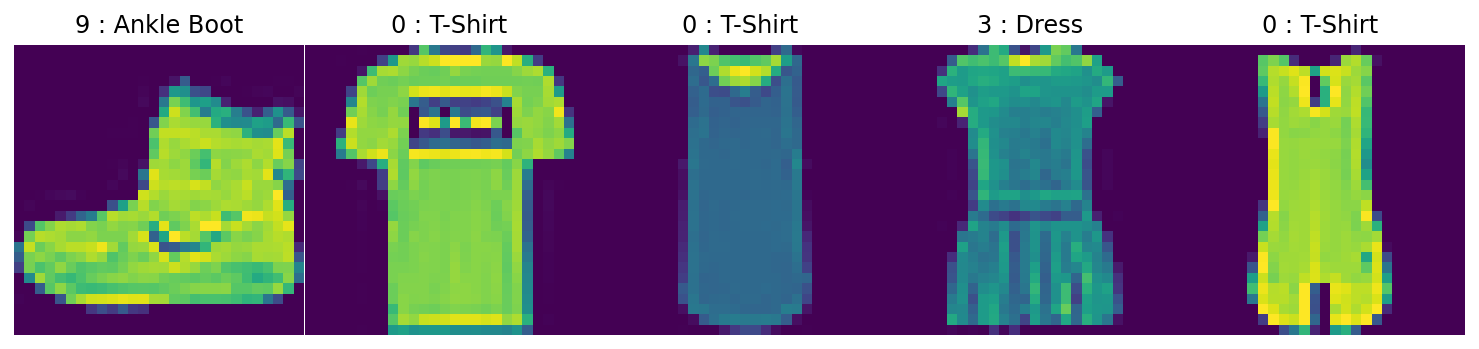

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

fig, axes = plt.subplots(1, 5, figsize=(13, 4))
plt.subplots_adjust(hspace=0.001, wspace=0.001)

for i in range(5):
    image, label = fmnist_train.__getitem__(i)
    axes[i].imshow(image.squeeze().numpy())
    axes[i].set_title(f'{label} : {labels_map[label]}')
    axes[i].axis('off')

## Toy Problem

### Define a modernized version of LeNet

- Replace all the average pooling with maximum pooling (``nn.AvgPool2d`` -> `nn.MaxPool2d`)
- Use ``ReLU`` instead of ``Sigmoid`` activation function.

(See [§6.6](./6.4_6.6%20CNN_2.ipynb) for the original version of LeNet.)

In [4]:
def net_fn():
    
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10)
        )
    
    return model

In [5]:
net = net_fn()
net.to(device)

# count total network parameters
print('Total network parameters :', sum(param.numel() for param in net.parameters() if param.requires_grad))

Total network parameters : 61706


In [6]:
batch_size = 256

train_loader = DataLoader(fmnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(fmnist_test, batch_size=batch_size, shuffle=True)

### Loss Function

In [7]:
criterion = nn.CrossEntropyLoss()

### Optimization Function

In [8]:
initial_lr = 0.3 # initial learning rate

optimizer = torch.optim.SGD(net.parameters(), lr=initial_lr)

### Learning Rate Scheduler


### SquareRootScheduler

``torch.optim.lr_scheduler.LambdaLR``

In [9]:
lambda1 = lambda epoch : (epoch+1)**-0.5  # For each epoch, multiply initial_lr*(epoch+1)^0.5
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda1)

### Training Loop

In [10]:
def train_1_epoch(model, optimizer, train_loss, train_acc, lr_record, scheduler=None):
    
    model.train()             # set model to training mode

    running_loss = 0.
    running_corrects = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device) 
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        
        # loss
        loss = criterion(outputs, labels) # predicted outputs v.s. actual labels
        
        # backwards
        optimizer.zero_grad()  # zero gradient
        loss.backward()        # loss.backward would calculate dloss/dw_i  
        optimizer.step()       # update network parameters (w_i)
        
        # compute statistics (avg. loss, accuracy)
        running_loss += loss.item() * labels.size(0)
        _, predictions = torch.max(outputs, 1)
        running_corrects += torch.sum(predictions == labels.data)
        
        #if (i+1)%300 == 0: # every 300 steps, print something
        #    print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{len(train_loader)}, loss={loss.item():.4f}')
    
    # -- End training for 1 epoch -- record statistics
    if scheduler:
        scheduler.step()
    
    lr_record.append(optimizer.state_dict()['param_groups'][0]['lr'])
    
    epoch_loss = running_loss / len(fmnist_train)            ; train_loss.append(epoch_loss)
    epoch_acc  = running_corrects / len(fmnist_train) * 100. ; train_acc.append(epoch_acc)
    print(f'>>> End epoch {epoch+1}, train accuracy = {epoch_acc:.2f}%, train avgLoss = {epoch_loss:.4f}')

    
    
def validation(model, valid_loss, valid_acc):
    
    model.eval()              # set model to evaluation mode
    
    running_loss = 0.
    running_corrects = 0
    
    for i, (images, labels) in enumerate(test_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # compute statistics (avg. loss, accuracy)
        running_loss += loss.item() * labels.size(0)
        _, predictions = torch.max(outputs, 1)
        running_corrects += torch.sum(predictions == labels.data)
    
    valid_loss.append(running_loss/len(test_loader.dataset))
    valid_acc.append(running_corrects/len(test_loader.dataset) * 100.)
    print(f'>>>              valid accuracy = {valid_acc[-1]:.2f}%, valid avgLoss = {valid_loss[-1]:.4f}')

In [11]:
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []
lr_record = []

num_epochs = 20
for epoch in range(0, num_epochs):
    train_1_epoch(net, optimizer, train_loss, train_acc, lr_record, scheduler)

    validation(net, valid_loss, valid_acc)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


>>> End epoch 1, train accuracy = 52.83%, train avgLoss = 1.2490
>>>              valid accuracy = 77.39%, valid avgLoss = 0.5834
>>> End epoch 2, train accuracy = 80.25%, train avgLoss = 0.5108
>>>              valid accuracy = 78.16%, valid avgLoss = 0.5835
>>> End epoch 3, train accuracy = 83.79%, train avgLoss = 0.4268
>>>              valid accuracy = 81.24%, valid avgLoss = 0.4858
>>> End epoch 4, train accuracy = 85.74%, train avgLoss = 0.3825
>>>              valid accuracy = 79.56%, valid avgLoss = 0.5514
>>> End epoch 5, train accuracy = 86.54%, train avgLoss = 0.3576
>>>              valid accuracy = 85.80%, valid avgLoss = 0.3858
>>> End epoch 6, train accuracy = 87.35%, train avgLoss = 0.3375
>>>              valid accuracy = 84.08%, valid avgLoss = 0.4259
>>> End epoch 7, train accuracy = 87.93%, train avgLoss = 0.3235
>>>              valid accuracy = 86.53%, valid avgLoss = 0.3664
>>> End epoch 8, train accuracy = 88.32%, train avgLoss = 0.3120
>>>              valid ac

### Plot Results : $\ \ \ \eta = \eta_0 (epoch+1)^{-0.5}$

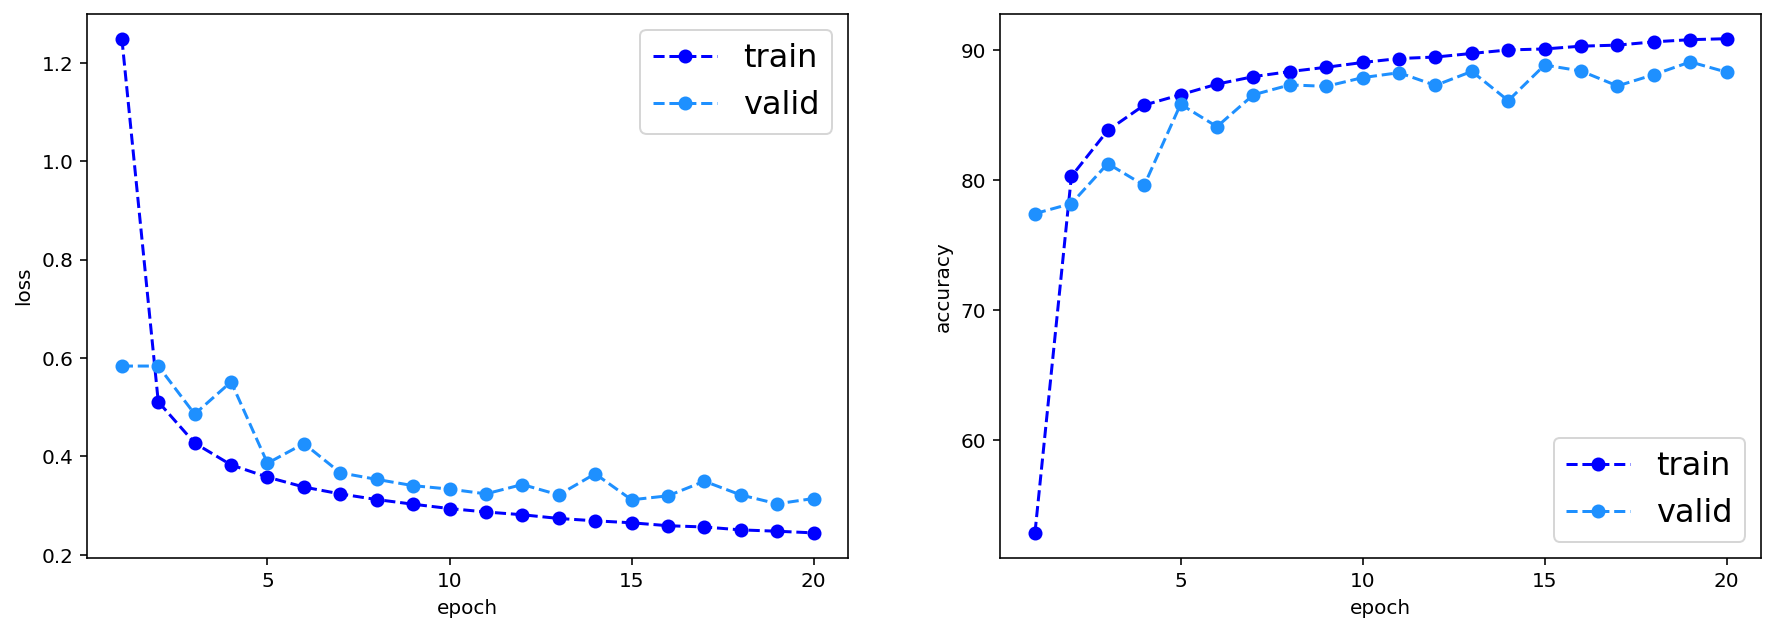

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.rc('font', size=16)

ax[0].plot(range(1,num_epochs+1)[::], train_loss[::], 'o--', label='train', color='b')
ax[0].plot(range(1,num_epochs+1)[::], valid_loss[::], 'o--', label='valid', color='dodgerblue')
ax[1].plot(range(1,num_epochs+1)[::], train_acc[::] , 'o--', label='train', color='b')
ax[1].plot(range(1,num_epochs+1)[::], valid_acc[::], 'o--', label='valid', color='dodgerblue')

ax[0].set_ylabel('loss')
ax[1].set_ylabel('accuracy')

for i in range(2):
    ax[i].set_xlabel('epoch')
    ax[i].legend(loc='best')

Text(0, 0.5, 'lr')

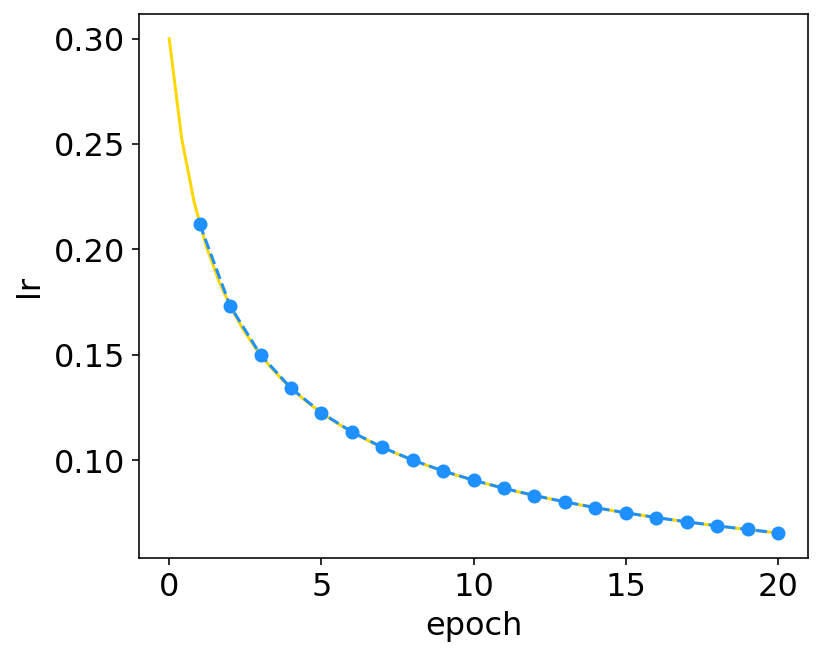

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.rc('font', size=16)

ax.plot(range(1,num_epochs+1), lr_record, 'o--', label='valid', color='dodgerblue')

x = np.linspace(0, num_epochs, 50)
plt.plot(x, initial_lr*(x+1)**-0.5, color='gold', zorder=-1)

ax.set_xlabel('epoch')
ax.set_ylabel('lr')

## Train without scheduler

In [14]:
net0 = net_fn()
net0.to(device)

optimizer0 = torch.optim.SGD(net0.parameters(), lr=initial_lr)

train_loss0 = []
train_acc0 = []
valid_loss0 = []
valid_acc0 = []
lr_record0 = []

num_epochs = 20
for epoch in range(0, num_epochs):
    train_1_epoch(net0, optimizer0, train_loss0, train_acc0, lr_record0, scheduler=None)
    validation(net0, valid_loss0, valid_acc0)

>>> End epoch 1, train accuracy = 55.20%, train avgLoss = 1.1778
>>>              valid accuracy = 74.82%, valid avgLoss = 0.6449
>>> End epoch 2, train accuracy = 80.54%, train avgLoss = 0.5123
>>>              valid accuracy = 80.69%, valid avgLoss = 0.5278
>>> End epoch 3, train accuracy = 84.99%, train avgLoss = 0.4032
>>>              valid accuracy = 84.22%, valid avgLoss = 0.4176
>>> End epoch 4, train accuracy = 86.73%, train avgLoss = 0.3557
>>>              valid accuracy = 81.53%, valid avgLoss = 0.4653
>>> End epoch 5, train accuracy = 87.56%, train avgLoss = 0.3309
>>>              valid accuracy = 85.75%, valid avgLoss = 0.3817
>>> End epoch 6, train accuracy = 88.30%, train avgLoss = 0.3098
>>>              valid accuracy = 84.93%, valid avgLoss = 0.4078
>>> End epoch 7, train accuracy = 88.86%, train avgLoss = 0.2939
>>>              valid accuracy = 86.61%, valid avgLoss = 0.3627
>>> End epoch 8, train accuracy = 89.20%, train avgLoss = 0.2850
>>>              valid ac

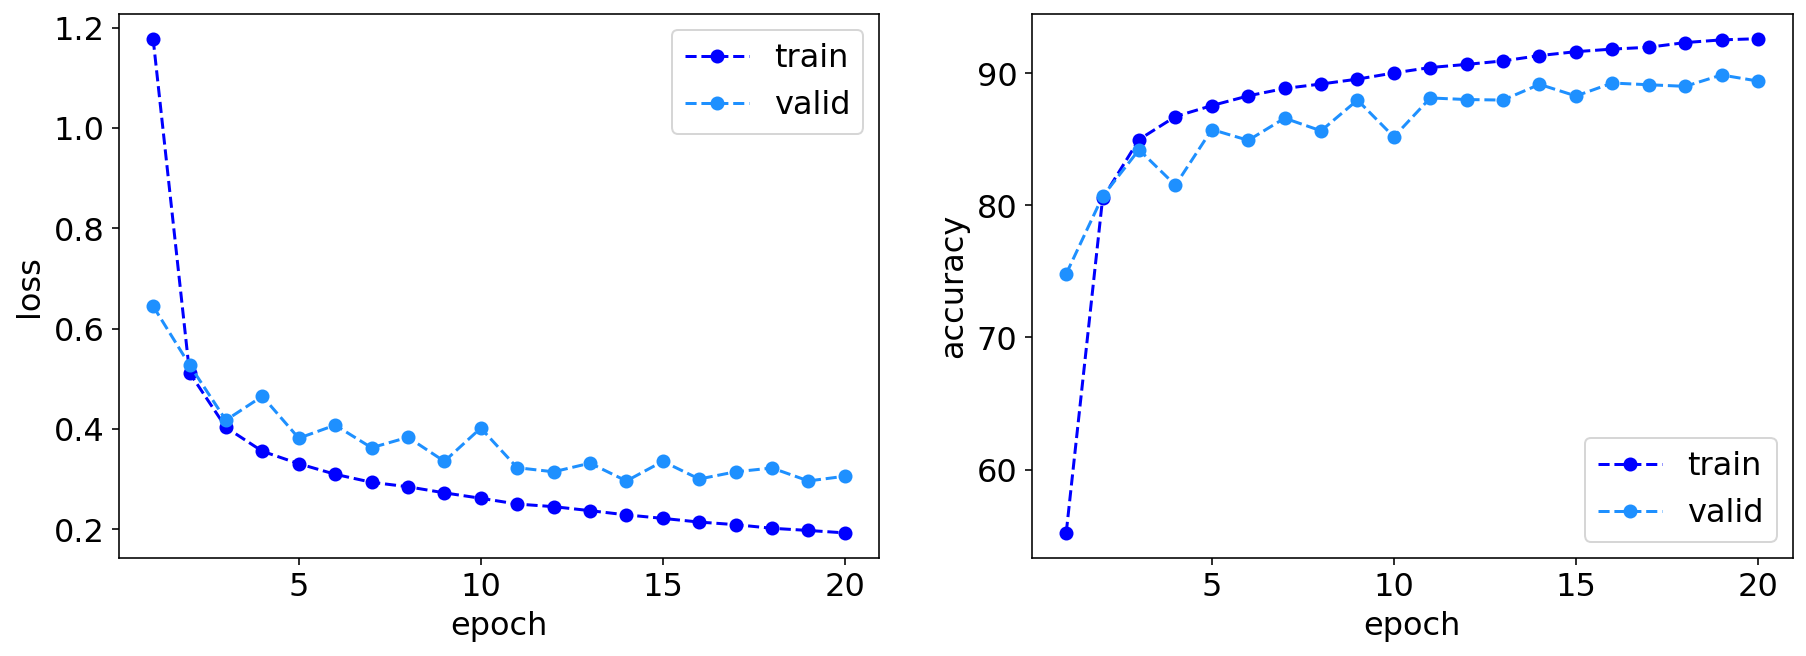

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.rc('font', size=16)

ax[0].plot(range(1,num_epochs+1)[::], train_loss0[::], 'o--', label='train', color='b')
ax[0].plot(range(1,num_epochs+1)[::], valid_loss0[::], 'o--', label='valid', color='dodgerblue')
ax[1].plot(range(1,num_epochs+1)[::], train_acc0[::] , 'o--', label='train', color='b')
ax[1].plot(range(1,num_epochs+1)[::], valid_acc0[::], 'o--', label='valid', color='dodgerblue')

ax[0].set_ylabel('loss')
ax[1].set_ylabel('accuracy')

for i in range(2):
    ax[i].set_xlabel('epoch')
    ax[i].legend(loc='best')

Text(0, 0.5, 'lr')

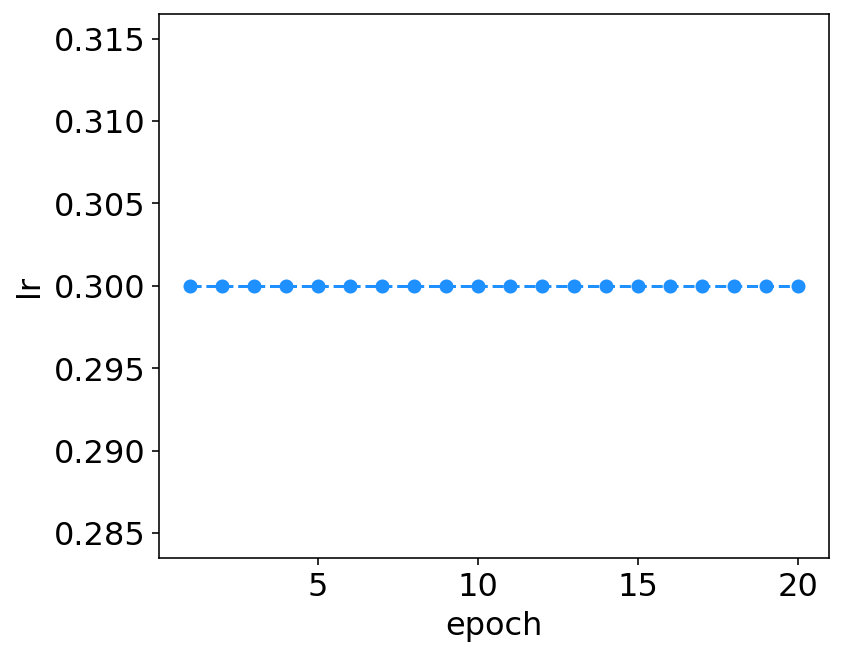

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.rc('font', size=16)

ax.plot(range(1,num_epochs+1), lr_record0, 'o--', label='valid', color='dodgerblue')

ax.set_xlabel('epoch')
ax.set_ylabel('lr')

## Other Types of Schedulers

### Factor Scheduler

``torch.optim.lr_scheduler.MultiplicativeLR``

In [17]:
initial_lr = 2
model0 = nn.Linear(10,1)
optimizerT = torch.optim.SGD(model0.parameters(), lr = initial_lr)

factor = 0.9
lmbda = lambda epoch : factor   # eta = eta*(factor)^epoch
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizerT, lmbda)

epochs = 20
lr_record = []

for epoch in range(epochs):
    optimizerT.step()
    scheduler.step()
    
    lr_record.append(optimizerT.state_dict()['param_groups'][0]['lr'])

Text(0, 0.5, 'lr')

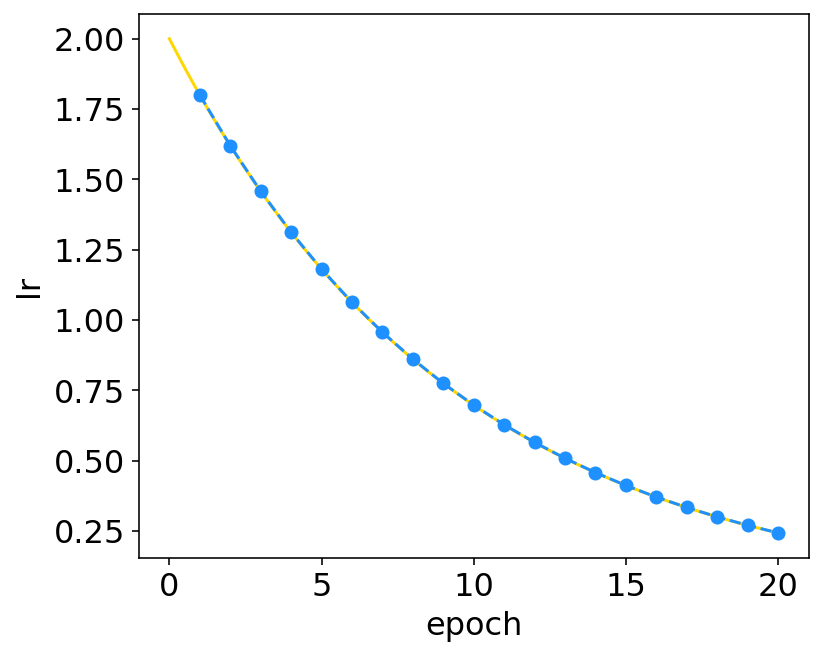

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.rc('font', size=16)

ax.plot(range(1,epochs+1), lr_record, 'o--', label='valid', color='dodgerblue')

x = np.linspace(0, epochs, 50)
plt.plot(x, initial_lr*0.9**x, color='gold', zorder=-1)

ax.set_xlabel('epoch')
ax.set_ylabel('lr')

### Multi Factor Scheduler 

```torch.optim.lr_scheduler.MultiStepLR```

**piecewise constant learning rate schedule**

In [19]:
initial_lr = 0.5
model0 = nn.Linear(10,1)
optimizerT = torch.optim.SGD(model0.parameters(), lr = initial_lr)


scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizerT, milestones=[15, 30], gamma=0.5)

epochs = 30
lr_record = []

for epoch in range(epochs):
    optimizerT.step()
    scheduler.step()
    
    #lr_record.append(optimizerT.state_dict()['param_groups'][0]['lr'])
    lr_record.append(scheduler.get_last_lr()[0])

Text(0, 0.5, 'lr')

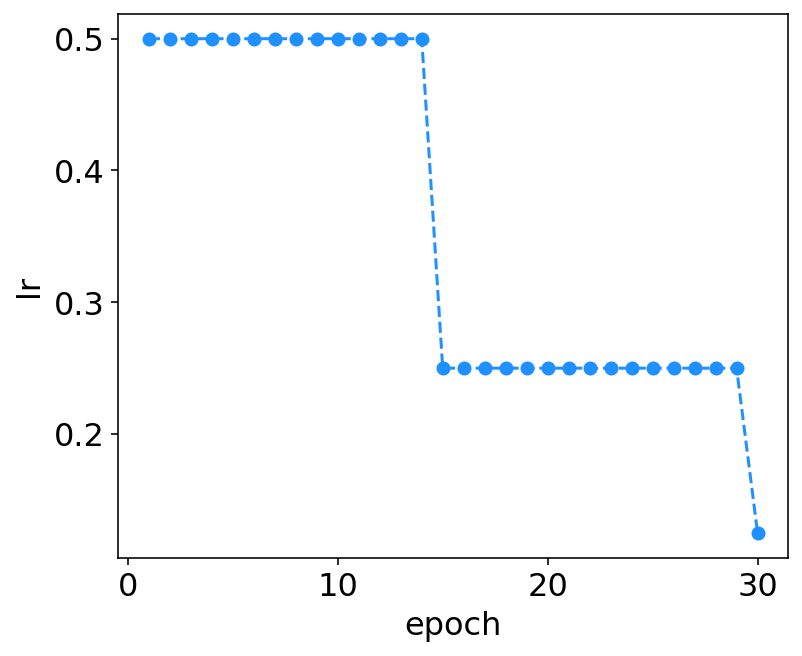

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.rc('font', size=16)

ax.plot(range(1,epochs+1), lr_record, 'o--', label='valid', color='dodgerblue')

ax.set_xlabel('epoch')
ax.set_ylabel('lr')